In [1]:
from fastkaggle import *

In [2]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not iskaggle and not cred_path.exists():
    raise Exception('Need to download kaggle credentials')

In [33]:
comp = 'tpu-getting-started'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
classes = ["pink primrose","hard-leaved pocket orchid","canterbury bells","sweet pea","wild geranium","tiger lily","moon orchid","bird of paradise","monkshood","globe thistle","snapdragon","colt's foot","king protea","spear thistle","yellow iris","globe-flower","purple coneflower","peruvian lily","balloon flower","giant white arum lily","fire lily","pincushion flower","fritillary","red ginger","grape hyacinth","corn poppy","prince of wales feathers","stemless gentian","artichoke","sweet william","carnation","garden phlox","love in the mist","cosmos","alpine sea holly","ruby-lipped cattleya","cape flower","great masterwort","siam tulip","lenten rose","barberton daisy","daffodil","sword lily","poinsettia","bolero deep blue","wallflower","marigold","buttercup","daisy","common dandelion","petunia","wild pansy","primula","sunflower","lilac hibiscus","bishop of llandaff","gaura","geranium","orange dahlia","pink-yellow dahlia","cautleya spicata","japanese anemone","black-eyed susan","silverbush","californian poppy","osteospermum","spring crocus","iris","windflower","tree poppy","gazania","azalea","water lily","rose","thorn apple","morning glory","passion flower","lotus","toad lily","anthurium","frangipani","clematis","hibiscus","columbine","desert-rose","tree mallow","magnolia","cyclamen ","watercress","canna lily","hippeastrum ","bee balm","pink quill","foxglove","bougainvillea","camellia","mallow","mexican petunia","bromelia","blanket flower","trumpet creeper","blackberry lily","common tulip","wild rose"]

In [4]:
path

Path('tpu-getting-started')

In [12]:
import timm
import functools
import itertools
from fastai.vision.all import *

path.ls()

(#5) [Path('tpu-getting-started/tfrecords-jpeg-512x512'),Path('tpu-getting-started/tfrecords-jpeg-224x224'),Path('tpu-getting-started/sample_submission.csv'),Path('tpu-getting-started/tfrecords-jpeg-331x331'),Path('tpu-getting-started/tfrecords-jpeg-192x192')]

In [35]:
data_paths = list(filter(lambda x: str(x) != "tpu-getting-started/sample_submission.csv", path.ls()))
data_paths = [Path('tpu-getting-started/tfrecords-jpeg-224x224')]
data_paths = functools.reduce(lambda acc, path: list(itertools.chain(acc, (path/'train').ls(), (path/'val').ls())), data_paths, [])

In [36]:
import tensorflow as tf

data = []
# https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file_in_python
raw_dataset = tf.data.TFRecordDataset(data_paths)

for record in raw_dataset:
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    datum = [
        example.features.feature['class'].int64_list.value[0],
        example.features.feature['image'].bytes_list.value[0]
    ]
    data.append(datum)

len(data)

2024-07-24 11:16:17.895442: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


16465

(224, 224)


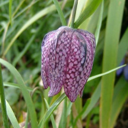

In [37]:
img = PILImage.create(data[0][1])
print(img.size)
img.to_thumb(128)

In [38]:
from fastcore.parallel import *

def f(o): return PILImage.create(o[1]).size
sizes = parallel(f, data, n_workers=8)
pd.Series(sizes).value_counts()

(224, 224)    16465
Name: count, dtype: int64

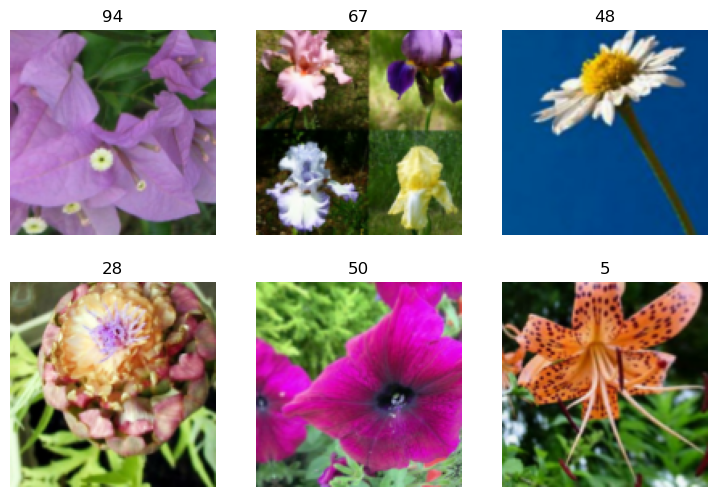

In [45]:
def get_items(*args, **kwargs): return data

get_x = lambda entry: PILImage.create(io.BytesIO(entry[1]))
get_y = lambda entry: entry[0]

block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=IndexSplitter(range(12753, len(data))),
                  item_tfms=[Resize(192, method='squish')],
                  batch_tfms=[*aug_transforms(size=128, min_scale=0.75)])

dls = block.dataloaders('', bs=64)
dls.show_batch(max_n=6)

In [11]:
# https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.multiclass_f1_score.html
